In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [88]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# between August 1st and August 7th from a previous year
vacay = calc_temps('2016-08-01', '2016-08-07')


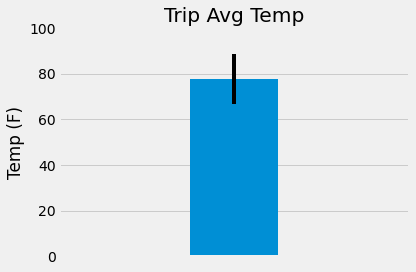

In [89]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#length of error bar
err = vacay[0][2] - vacay[0][0]

#plot
plt.bar(x=0, height=vacay[0][1], width=.1)
plt.title("Trip Avg Temp")
plt.xlim(-0.2,0.2)
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.errorbar(x=0, y=vacay[0][1], yerr=err, ecolor='black')
plt.xticks([])
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [91]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#session query station, date and prcp from Measurement
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-01').filter(Measurement.date <= '2016-08-07').all()
#query all from Station
station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
#close session
session.close()

#turn queries into dataframes
m = pd.DataFrame(results).set_index('date')
s = pd.DataFrame(station).set_index(np.arange(1,10))

#group measurment by station
grouped_m = m.groupby("station")

#get total rainfall
total_rainfall = grouped_m['prcp'].sum()

#join dataframes
joined_info = s.merge(total_rainfall, how='left', on='station')
joined_info.sort_values('prcp',ascending=False)

,station,name,latitude,longitude,elevation,prcp
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.02
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.65
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,3.59
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.30
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.03
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.57
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.18
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


In [92]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [116]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(x) for x in date_range]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [125]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals[0], columns=['tmin', 'tavg', 'tmax'])
df

,tmin,tavg,tmax
0,67.0,75.54,83.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session